# Should Eleanor go to the birthday trips?

## Covid 19 Trending Analysis / Forecasting Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import re
# import os
# import zipfile
# from io import BytesIO, StringIO
# import pprint
# from google.colab import drive
# import operator
# drive.mount('/content/drive')

https://covid.cdc.gov/covid-data-tracker/#datatracker-home
\
https://data.cdc.gov/Public-Health-Surveillance/NWSS-Public-SARS-CoV-2-Wastewater-Metric-Data/2ew6-ywp6/about_data
\
https://www.today.com/health/coronavirus/covid-wastewater-monitoring-rcna143158
\
https://www.usatoday.com/story/graphics/2024/01/16/covid-19-virus-wastewater-levels-increase/72189122007/


In [2]:
# !ls

# 1. Extract and Pre-Process the data

In [3]:
df = pd.read_csv('NWSS_Public_SARS-CoV-2_Wastewater_Metric_Data_20240316.csv')
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'])
df['first_sample_date'] = pd.to_datetime(df['first_sample_date'])
# data transformation
# df['log_ptc_15d'] = np.log(df['ptc_15d'])

# filter to 2024 data and check the shape again
df = df[ (df['date_start']>= '2022-01-01') & (df['percentile']<=100)].sort_values(by='date_start')
df_nj = df[ (df['date_start']>= '2022-01-01') & (df['reporting_jurisdiction'] == 'New Jersey')].sort_values(by='date_start')
df_mx = df[ (df['date_start']>= '2022-01-01') & (df['reporting_jurisdiction'] == 'New Jersey') & (df['county_names']=='Middlesex,Somerset,Union')].sort_values(by='date_start')

print('number of samples since 2022', df.shape)
print('number of samples for NJ since 2022', df_nj.shape)
print('number of samples for Middlesex, Somerset, Union since 2023', df_mx.shape)

# pull the records and take a look
# df.sort_values(by='date_start')
df[['reporting_jurisdiction', 'county_names', 'date_start', 'date_end', 'ptc_15d', 'detect_prop_15d','percentile']].head()

number of samples since 2022 (607536, 16)
number of samples for NJ since 2022 (9086, 16)
number of samples for Middlesex, Somerset, Union since 2023 (408, 16)


,reporting_jurisdiction,county_names,date_start,date_end,ptc_15d,detect_prop_15d,percentile
869,Missouri,"Cole,Callaway",2022-01-01,2022-01-15,84.0,100.0,98.000
658603,Missouri,Buchanan,2022-01-01,2022-01-15,-100.0,50.0,50.500
129662,Houston,Harris,2022-01-01,2022-01-15,-51.0,100.0,63.000
582718,Oregon,Marion,2022-01-01,2022-01-15,-41.0,100.0,95.333
284337,Oregon,Columbia,2022-01-01,2022-01-15,-7.0,100.0,96.750


In [4]:
df_nj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9086 entries, 568111 to 633717
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   wwtp_jurisdiction        9086 non-null   object        
 1   wwtp_id                  9086 non-null   int64         
 2   reporting_jurisdiction   9086 non-null   object        
 3   sample_location          9086 non-null   object        
 4   sample_location_specify  0 non-null      float64       
 5   key_plot_id              9086 non-null   object        
 6   county_names             9086 non-null   object        
 7   county_fips              9086 non-null   object        
 8   population_served        9086 non-null   int64         
 9   date_start               9086 non-null   datetime64[ns]
 10  date_end                 9086 non-null   datetime64[ns]
 11  ptc_15d                  8995 non-null   float64       
 12  detect_prop_15d          9086 no

In [5]:
# print(min(df_nj.date_start),max(df_nj.date_start))
# print(min(df_nj.date_end), max(df_nj.date_end))

## Understand the Metrics
#### ptc_15d (float64)      
The percent change in SARS-CoV-2 RNA levels over the 15-day interval defined by 'date_start' and 'date_end'. Percent change is calculated as the modeled change over the interval, based on linear regression of log-transformed SARS-CoV-2 levels. SARS-CoV-2 RNA levels are wastewater concentrations that have been normalized for wastewater composition.\
**very sensitive, so I will use the log(ptc_15d) instead**

#### detect_prop_15d (float64)  
The proportion of tests with SARS-CoV-2 detected, meaning a cycle threshold (Ct) value <40 for RT-qPCR or at least 3 positive droplets/partitions for RT-ddPCR, by sewershed over the 15-day window defined by 'date_start' and "date_end'. The detection proportion is the percent calculated by dividing the 15-day rolling sum of SARS-CoV-2 detections by the 15-day rolling sum of the number of tests for each sewershed and multiplying by 100.\
**insensitive and mostly at 100 so I won't use this metric** 

#### percentile (float64)       
This metric shows whether SARS-CoV-2 virus levels at a site are currently higher or lower than past historical levels at the same site. 0% means levels are the lowest they have been at the site; 100% means levels are the highest they have been at the site. Public health officials watch for increasing levels of the virus in wastewater over time and use this data to help make public health decisions.\
**best bet. sensitive enough, and desrciption align my goal**


In [6]:
df_nj.describe()

,wwtp_id,sample_location_specify,population_served,date_start,date_end,ptc_15d,detect_prop_15d,percentile,first_sample_date
count,9086.000000,0.0,9.086000e+03,9086,9086,8.995000e+03,9086.000000,9086.000000,9086
mean,1839.996368,NaN,3.313708e+05,2023-09-02 19:33:35.144177920,2023-09-16 19:33:35.144178176,9.088631e+06,99.283183,50.066666,2023-03-24 20:49:49.038080768
min,784.000000,NaN,5.500000e+03,2022-07-22 00:00:00,2022-08-05 00:00:00,-1.000000e+02,0.000000,0.000000,2022-08-05 00:00:00
25%,1385.000000,NaN,3.000000e+04,2023-06-15 00:00:00,2023-06-29 00:00:00,-3.700000e+01,100.000000,30.600000,2023-01-30 00:00:00
50%,2107.000000,NaN,5.267200e+04,2023-09-17 00:00:00,2023-10-01 00:00:00,1.000000e+00,100.000000,49.225000,2023-03-09 00:00:00
75%,2353.000000,NaN,2.500000e+05,2023-12-07 00:00:00,2023-12-21 00:00:00,7.100000e+01,100.000000,69.600000,2023-06-07 00:00:00
max,2619.000000,NaN,1.500000e+06,2024-02-27 00:00:00,2024-03-12 00:00:00,2.147484e+09,100.000000,97.800000,2023-10-02 00:00:00
std,590.223374,NaN,5.132712e+05,NaN,NaN,1.392914e+08,4.948612,24.012313,NaN


# 2. Exploratory Data Analysis
### what does the data look like

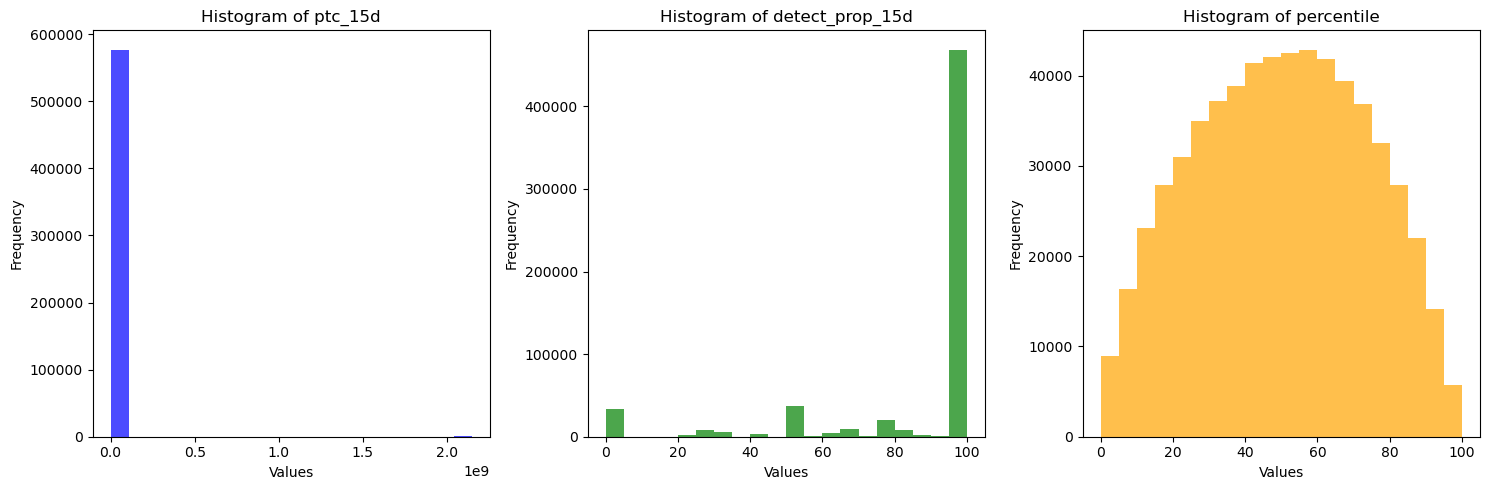

In [7]:
# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting histograms
axs[0].hist(df['ptc_15d'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Histogram of ptc_15d')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')

axs[1].hist(df['detect_prop_15d'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Histogram of detect_prop_15d')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')

axs[2].hist(df['percentile'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('Histogram of percentile')
axs[2].set_xlabel('Values')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

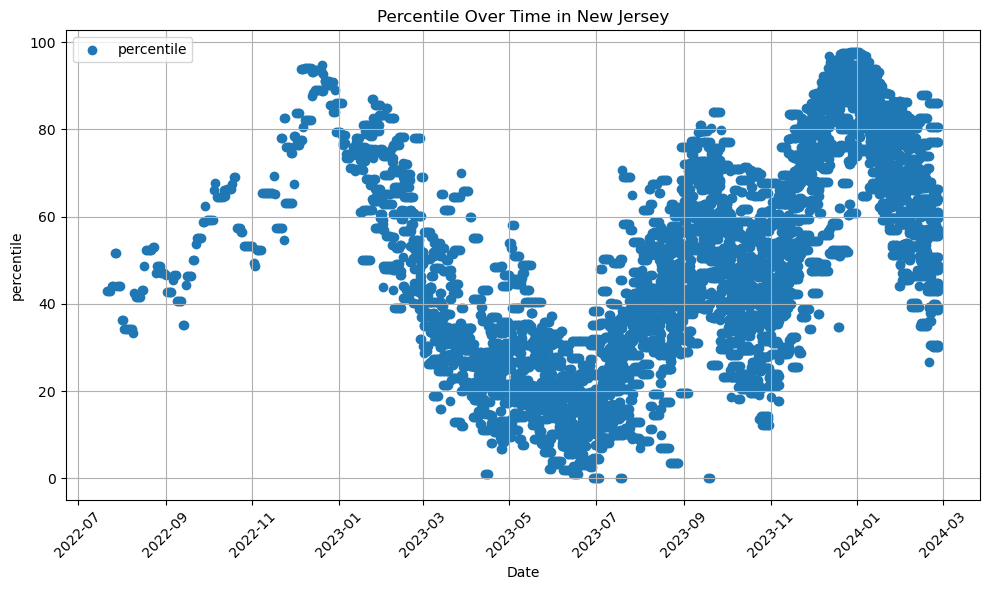

In [8]:
# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(df_nj['date_start'], df_nj['percentile'], label='percentile', marker='o')
# plt.plot(df_mx['date_start'], np.log(df_mx['ptc_15d']), label='ptc_15d', marker='x')
# plt.plot(df_mx['date_start'], df_mx['detect_prop_15d'], label='detect_prop_15d', marker='x')

plt.title('Percentile Over Time in New Jersey')
plt.xlabel('Date')
plt.ylabel('percentile')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()

plt.show()

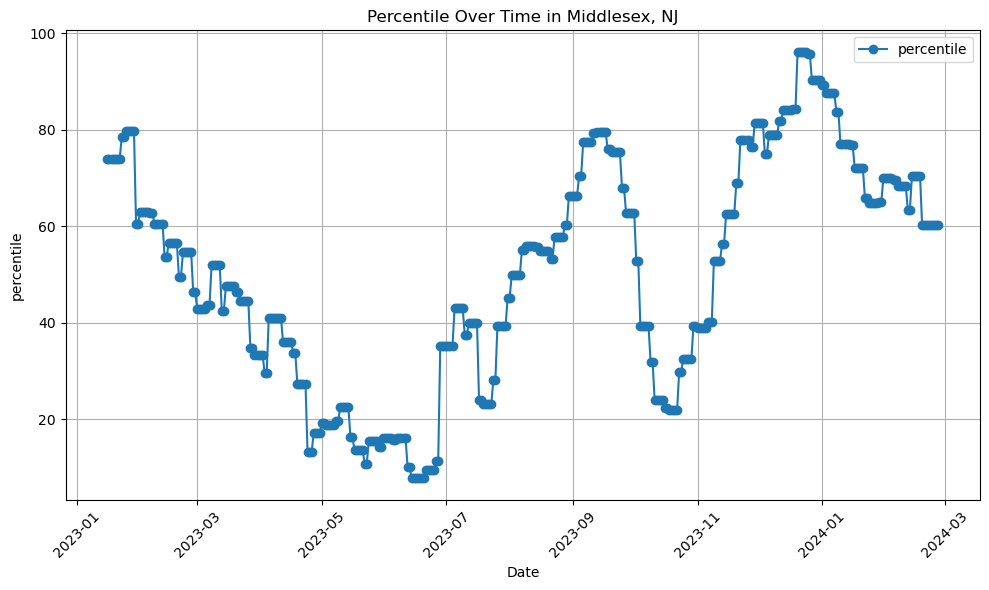

In [9]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df_mx['date_start'], df_mx['percentile'], label='percentile', marker='o')
# plt.plot(df_mx['date_start'], np.log(df_mx['ptc_15d']), label='ptc_15d', marker='x')
# plt.plot(df_mx['date_start'], df_mx['detect_prop_15d'], label='detect_prop_15d', marker='x')

plt.title('Percentile Over Time in Middlesex, NJ')
plt.xlabel('Date')
plt.ylabel('percentile')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()

plt.show()

In [10]:
top_population_county = df_nj.groupby('county_names', as_index=0)[['population_served']].mean().sort_values('population_served', ascending=False)
print(top_population_county)

# Function to determine county_top_5
def determine_county(population, county_name):
    if population > 1000000:
        return county_name
    else:
        return 'other'

# Applying the function to create county_top_5 column
df_nj['county_top_5'] = df_nj.apply(lambda row: determine_county(row['population_served'], row['county_names']), axis=1)

df_nj.sample(10)


                         county_names  population_served
4         Essex,Hudson,Passaic,Bergen       1.500000e+06
5   Essex,Hudson,Union,Passaic,Bergen       1.500000e+06
6                         Essex,Union       1.300000e+06
9            Middlesex,Somerset,Union       8.800000e+05
1                              Bergen       5.645630e+05
16                              Union       2.041480e+05
0                            Atlantic       1.073170e+05
7                              Hudson       9.708407e+04
14                           Somerset       7.427256e+04
10                           Monmouth       5.587440e+04
11                             Morris       5.518292e+04
12                            Passaic       5.400000e+04
3                          Cumberland       3.719764e+04
2                          Burlington       1.998000e+04
8                           Hunterdon       9.440000e+03
15                             Sussex       7.751000e+03
13                             

,wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,sample_location_specify,key_plot_id,county_names,county_fips,population_served,date_start,date_end,ptc_15d,detect_prop_15d,percentile,sampling_prior,first_sample_date,county_top_5
392295,New Jersey,2350,New Jersey,Treatment plant,NaN,NWSS_nj_2350_Treatment plant_raw wastewater,Morris,34027,24530,2024-02-08,2024-02-22,-52.0,100.0,52.600,no,2023-05-17,other
10330,New Jersey,2222,New Jersey,Treatment plant,NaN,WWS_nj_2222_Treatment plant_primary sludge,Monmouth,34025,100000,2023-10-27,2023-11-10,-4.0,100.0,44.000,no,2023-04-28,other
447068,New Jersey,1907,New Jersey,Treatment plant,NaN,WWS_nj_1907_Treatment plant_primary sludge,Monmouth,34025,52672,2023-11-03,2023-11-17,20.0,100.0,46.000,no,2022-12-05,other
483534,New Jersey,2377,New Jersey,Treatment plant,NaN,NWSS_nj_2377_Treatment plant_raw wastewater,Monmouth,34025,47357,2023-08-06,2023-08-20,237969.0,100.0,24.000,no,2023-08-15,other
483634,New Jersey,2377,New Jersey,Treatment plant,NaN,NWSS_nj_2377_Treatment plant_raw wastewater,Monmouth,34025,47357,2023-11-14,2023-11-28,-21.0,100.0,51.800,no,2023-08-15,other
366484,New Jersey,1385,New Jersey,Treatment plant,NaN,NWSS_nj_1385_Treatment plant_raw wastewater,Hudson,34017,145000,2024-02-25,2024-03-10,-43.0,100.0,44.800,no,2023-01-30,other
511887,New Jersey,2400,New Jersey,Treatment plant,NaN,NWSS_nj_2400_Treatment plant_raw wastewater,Salem,34033,5500,2024-01-26,2024-02-09,1528.0,100.0,57.000,no,2023-08-29,other
14449,New Jersey,2352,New Jersey,Treatment plant,NaN,NWSS_nj_2352_Treatment plant_raw wastewater,Cumberland,34011,30000,2024-01-18,2024-02-01,-42.0,100.0,88.400,no,2023-06-06,other
446892,New Jersey,1907,New Jersey,Treatment plant,NaN,WWS_nj_1907_Treatment plant_primary sludge,Monmouth,34025,52672,2023-05-11,2023-05-25,-7.0,100.0,7.571,no,2022-12-05,other
108832,New Jersey,2356,New Jersey,Treatment plant,NaN,NWSS_nj_2356_Treatment plant_raw wastewater,Hudson,34017,22181,2023-12-11,2023-12-25,195.0,100.0,82.000,no,2023-06-21,other


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


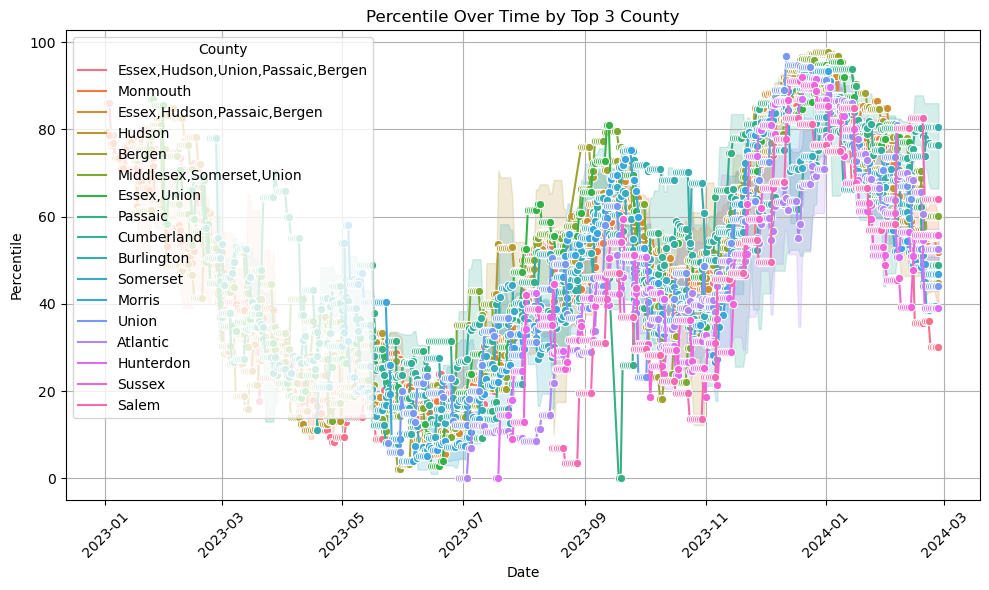

In [11]:
# bring ing multiple county and only look at percentiles

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_nj[df_nj['date_start']>'2023-01-01'], x='date_start', y='percentile', hue='county_names', marker='o')

plt.title('Percentile Over Time by Top 3 County')
plt.xlabel('Date')
plt.ylabel('Percentile')
plt.legend(title='County')

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


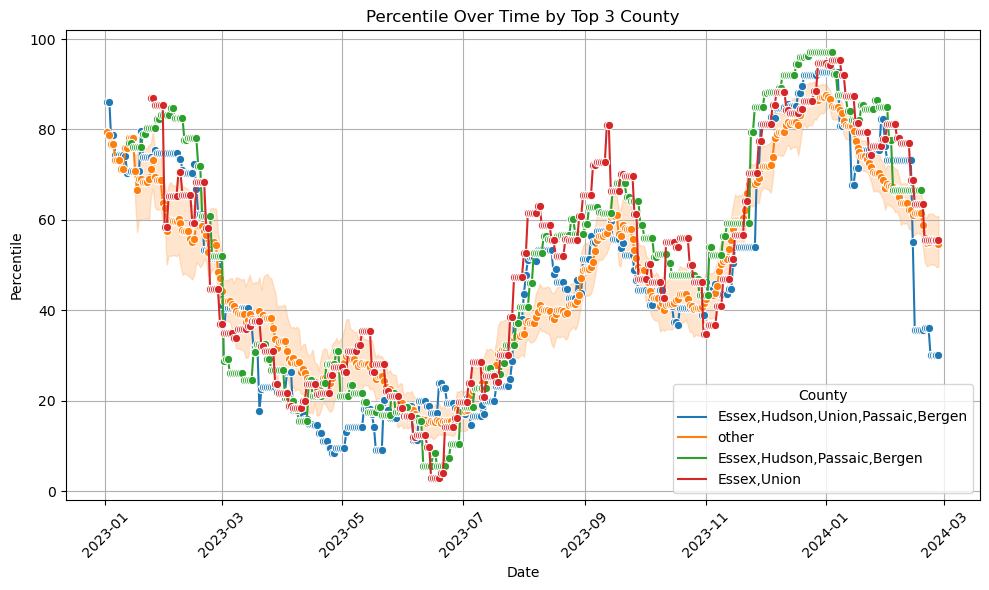

In [12]:
# bring ing multiple county and only look at percentiles

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_nj[df_nj['date_start']>'2023-01-01'], x='date_start', y='percentile', hue='county_top_5', marker='o')

plt.title('Percentile Over Time by Top 3 County')
plt.xlabel('Date')
plt.ylabel('Percentile')
plt.legend(title='County')

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

# Compare with COVID 19 case data
## ...and see if I can use the waster water to proxy the covid # case

https://covid.cdc.gov/covid-data-tracker/#trends_weeklyhospitaladmissions_select_34

In [13]:
case = pd.read_csv('data_table_for_weekly_covid19_hospital_admissions_-_new_jersey.csv', skiprows=2)
case['dt'] = pd.to_datetime(case['Date'])
case.rename(columns = {'Weekly COVID-19 Hospital Admissions':'weekly_case'}, inplace=True)
print(min(case['dt']))
print(max(case['dt']))
case.head()

2020-01-11 00:00:00
2024-03-09 00:00:00


,Geography,Date,weekly_case,dt
0,New Jersey,Mar 9 2024,390.0,2024-03-09
1,New Jersey,Mar 2 2024,521.0,2024-03-02
2,New Jersey,Feb 24 2024,552.0,2024-02-24
3,New Jersey,Feb 17 2024,646.0,2024-02-17
4,New Jersey,Feb 10 2024,694.0,2024-02-10


In [14]:
# prep the percentile data from df_nj
avg = df_nj.groupby('date_start', as_index=0)[['percentile']].mean()
print(min(avg['date_start']))

2022-07-22 00:00:00


In [15]:
combined = avg.merge(case, how='inner', left_on='date_start', right_on='dt')
print(combined.shape)
combined.head()

(84, 6)


,date_start,percentile,Geography,Date,weekly_case,dt
0,2022-07-23,43.000,New Jersey,Jul 23 2022,1133.0,2022-07-23
1,2022-07-30,44.000,New Jersey,Jul 30 2022,1167.0,2022-07-30
2,2022-08-06,34.143,New Jersey,Aug 6 2022,1139.0,2022-08-06
3,2022-08-13,41.571,New Jersey,Aug 13 2022,1118.0,2022-08-13
4,2022-08-20,52.286,New Jersey,Aug 20 2022,1054.0,2022-08-20


In [16]:
# combined.rename(columns = {'Weekly COVID-19 Hospital Admissions':'weekly_case'}, inplace=True)

In [17]:
combined.sample(5)

,date_start,percentile,Geography,Date,weekly_case,dt
33,2023-03-11,37.962333,New Jersey,Mar 11 2023,590.0,2023-03-11
36,2023-04-01,31.044308,New Jersey,Apr 1 2023,372.0,2023-04-01
43,2023-05-20,24.204353,New Jersey,May 20 2023,129.0,2023-05-20
68,2023-11-11,50.993679,New Jersey,Nov 11 2023,439.0,2023-11-11
57,2023-08-26,42.775040,New Jersey,Aug 26 2023,314.0,2023-08-26


In [18]:
print(min(combined['dt']), max(combined['dt']))

2022-07-23 00:00:00 2024-02-24 00:00:00


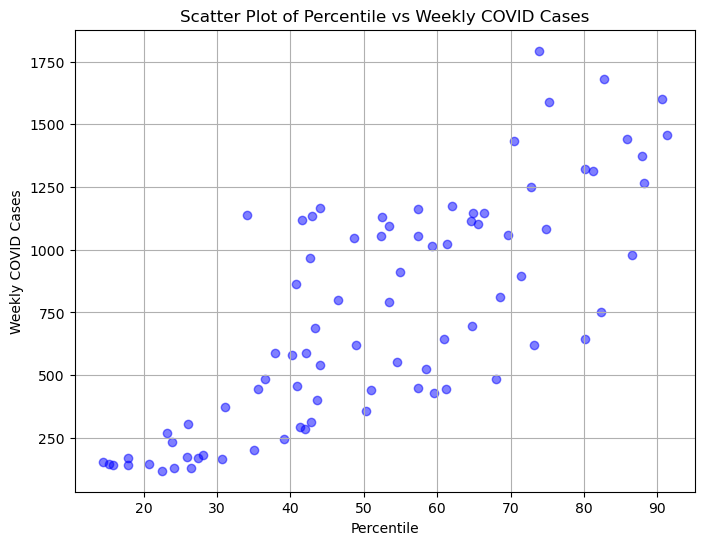

In [19]:
# Plotting the scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(combined['percentile'], combined['weekly_case'], color='blue', alpha=0.5)
plt.title('Scatter Plot of Percentile vs Weekly COVID Cases')
plt.xlabel('Percentile')
plt.ylabel('Weekly COVID Cases')
plt.grid(True)
plt.show()

In [20]:
combined['weekly_case_normalized'] = (combined['weekly_case'] - combined['weekly_case'].min()) / (combined['weekly_case'].max() - combined['weekly_case'].min())
combined['percentile_normalized'] = (combined['percentile'] - combined['percentile'].min()) / (combined['percentile'].max() - df['percentile'].min())

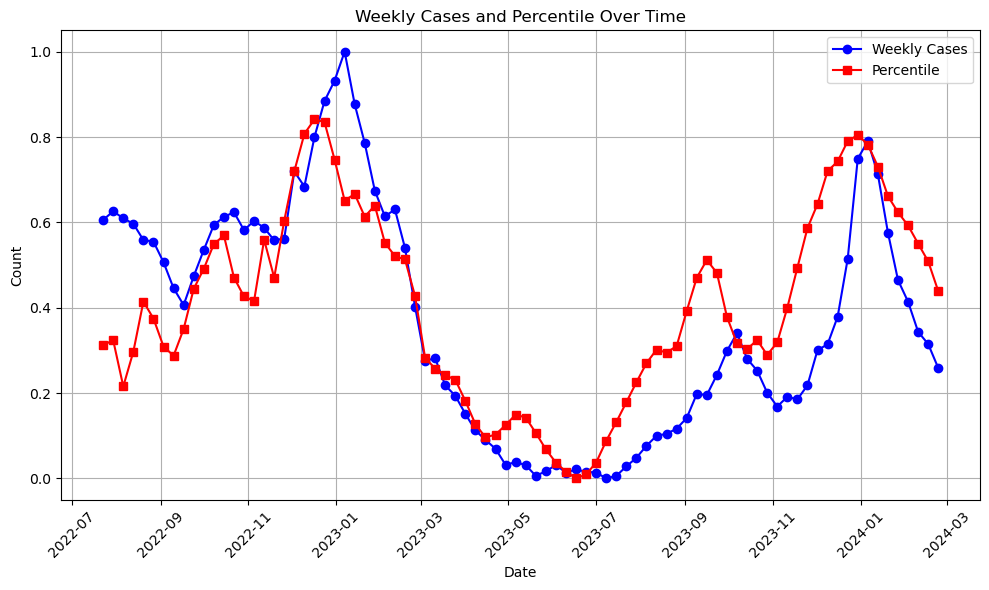

In [21]:
# Plotting the line chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting weekly cases
plt.plot(combined['dt'], combined['weekly_case_normalized'], marker='o', color='blue', label='Weekly Cases')

# Plotting percentiles
plt.plot(combined['dt'], combined['percentile_normalized'], marker='s', color='red', label='Percentile')

# Adding title and labels
plt.title('Weekly Cases and Percentile Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()  # Show legend
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

# Estimate the correlation coefficient between percentile to weekly case

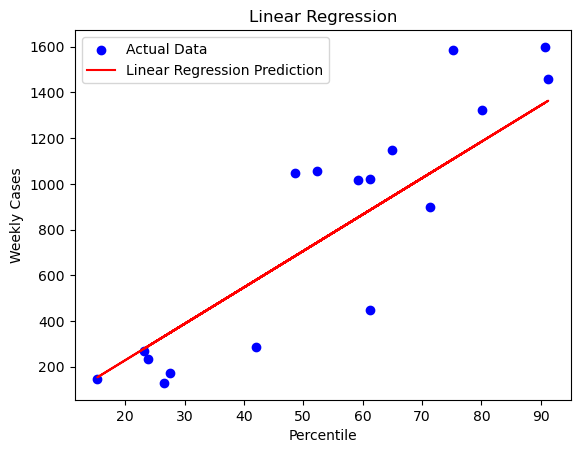

Coefficients: [15.93752192]


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Splitting data into features (X) and target variable (y)
X = combined[['percentile']]
y = combined['weekly_case']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=42

# Creating Linear Regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Plotting the results
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, y_pred, color='red', label='Linear Regression Prediction')
plt.title('Linear Regression')
plt.xlabel('Percentile')
plt.ylabel('Weekly Cases')
plt.legend()
plt.show()

# Coefficients
print('Coefficients:', model.coef_)

# Intercept
# print('Intercept:', model.intercept_)



In [23]:
import statsmodels.api as sm

# Adding constant term for intercept
X = sm.add_constant(combined['percentile'])
y = combined['weekly_case']

# Fitting the model
model = sm.OLS(y, X).fit()

# Printing summary table
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_case   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     128.0
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           2.00e-18
Time:                        16:57:04   Log-Likelihood:                -592.51
No. Observations:                  84   AIC:                             1189.
Df Residuals:                      82   BIC:                             1194.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -139.6540     83.927     -1.664      0.1

## 17.0681 case given one percentile up

# Time series forecasting

In [49]:
df_mx.head()

,wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,sample_location_specify,key_plot_id,county_names,county_fips,population_served,date_start,date_end,ptc_15d,detect_prop_15d,percentile,sampling_prior,first_sample_date
161026,New Jersey,784,New Jersey,Treatment plant,NaN,NWSS_nj_784_Treatment plant_post grit removal,"Middlesex,Somerset,Union","34039,34035,34023",880000,2023-01-16,2023-01-30,NaN,100.0,74.0,no,2023-01-30
161027,New Jersey,784,New Jersey,Treatment plant,NaN,NWSS_nj_784_Treatment plant_post grit removal,"Middlesex,Somerset,Union","34039,34035,34023",880000,2023-01-17,2023-01-31,NaN,100.0,74.0,no,2023-01-30
161028,New Jersey,784,New Jersey,Treatment plant,NaN,NWSS_nj_784_Treatment plant_post grit removal,"Middlesex,Somerset,Union","34039,34035,34023",880000,2023-01-18,2023-02-01,3.0,100.0,74.0,no,2023-01-30
161029,New Jersey,784,New Jersey,Treatment plant,NaN,NWSS_nj_784_Treatment plant_post grit removal,"Middlesex,Somerset,Union","34039,34035,34023",880000,2023-01-19,2023-02-02,3.0,100.0,74.0,no,2023-01-30
161030,New Jersey,784,New Jersey,Treatment plant,NaN,NWSS_nj_784_Treatment plant_post grit removal,"Middlesex,Somerset,Union","34039,34035,34023",880000,2023-01-20,2023-02-03,3.0,100.0,74.0,no,2023-01-30


In [37]:
print(df_mx.shape)
print(min(df_mx['date_start']), max(df_mx['date_start']))

(408, 16)
2023-01-16 00:00:00 2024-02-27 00:00:00


In [38]:
# Python
# import pandas as pd
from prophet import Prophet

In [39]:
ph_df = df_mx[['date_start', 'percentile']].rename(columns={'date_start':'ds', 'percentile':'y'})
# ph_df.sample()

m = Prophet()

m.fit(ph_df)

21:48:48 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
future = m.make_future_dataframe(periods=360)
future.tail()

,ds
763,2025-02-17
764,2025-02-18
765,2025-02-19
766,2025-02-20
767,2025-02-21


In [44]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
763,2025-02-17,143.748135,95.510775,192.801234
764,2025-02-18,143.889796,93.158283,194.825291
765,2025-02-19,145.986555,98.083793,197.692531
766,2025-02-20,146.415611,97.549087,196.179245
767,2025-02-21,146.557118,97.709141,196.542783


/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



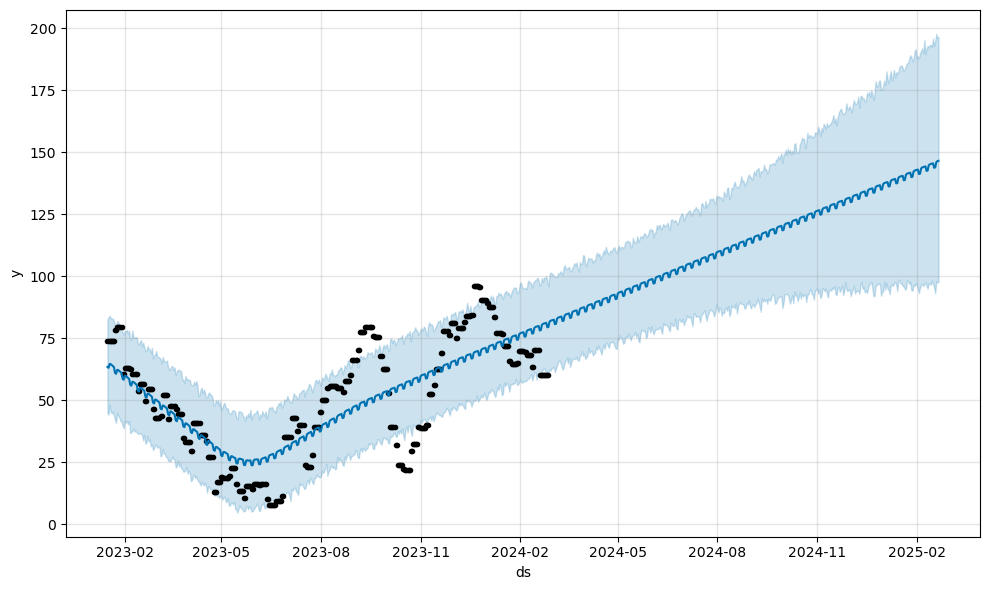

In [45]:
fig1 = m.plot(forecast)



/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



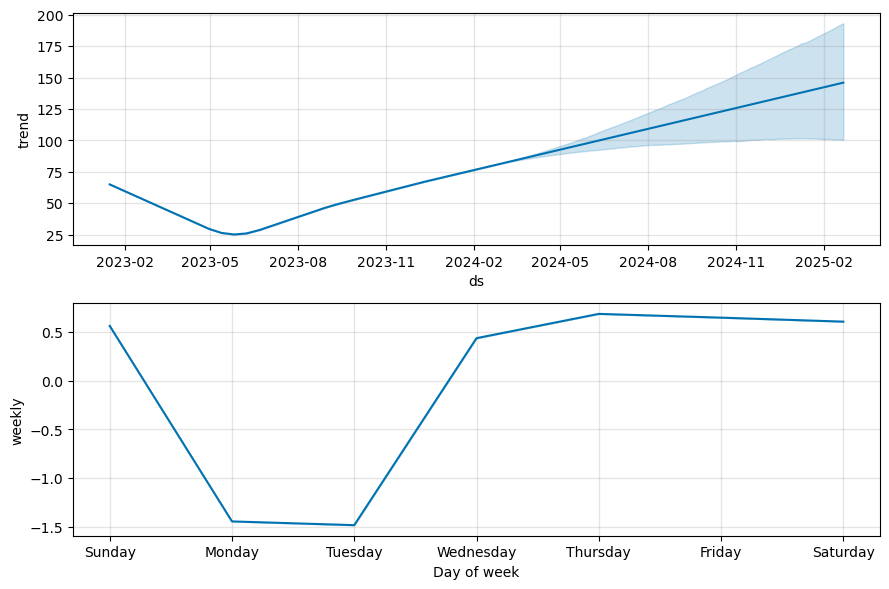

In [46]:
fig2 = m.plot_components(forecast)



/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



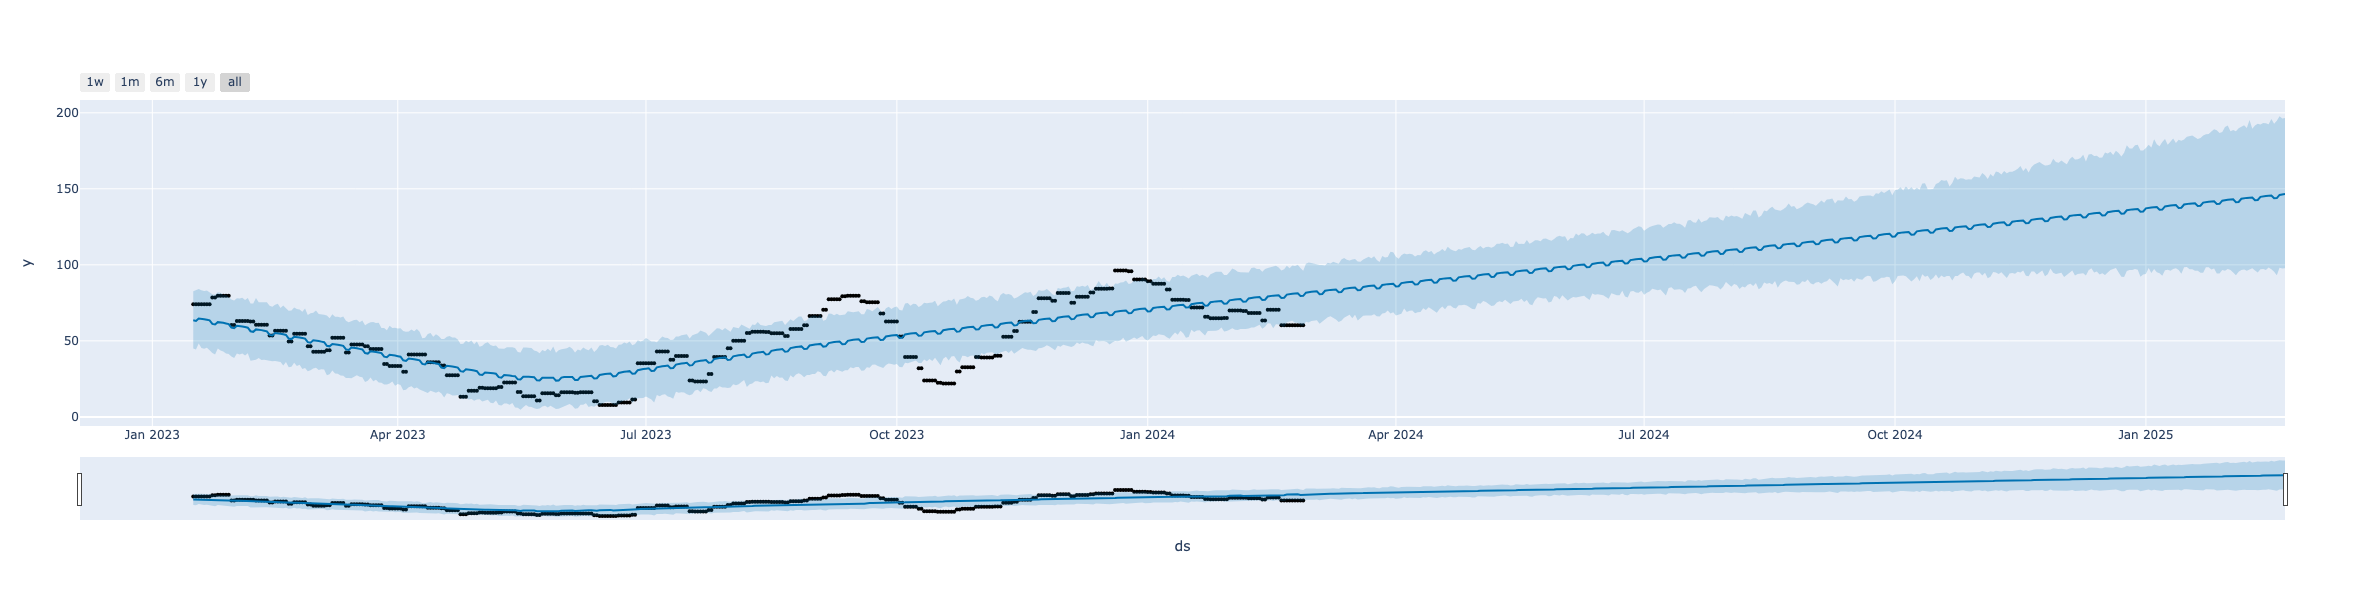

In [47]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



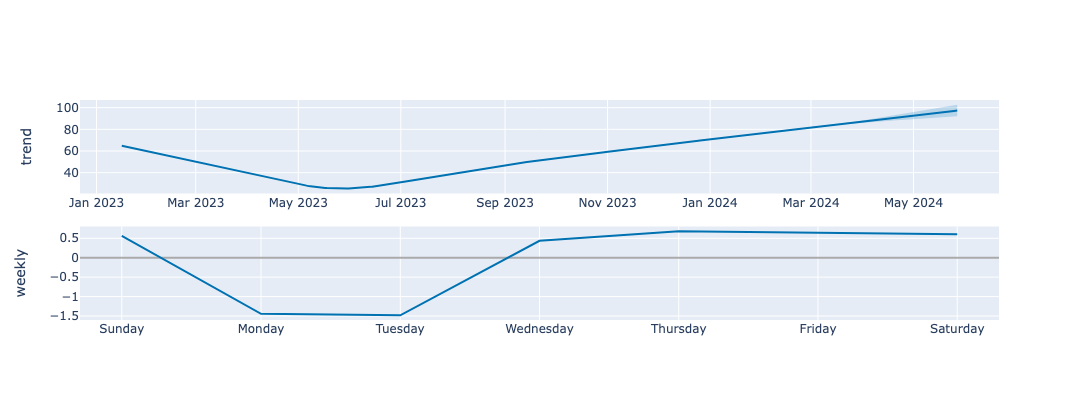

In [33]:
plot_components_plotly(m, forecast)

In [50]:
avg.head()

,date_start,percentile
0,2022-07-22,43.0
1,2022-07-23,43.0
2,2022-07-24,43.0
3,2022-07-25,44.0
4,2022-07-26,44.0


In [51]:
print(avg.shape)
print(min(avg['date_start']), max(avg['date_start']))

(586, 2)
2022-07-22 00:00:00 2024-02-27 00:00:00


21:59:48 - cmdstanpy - INFO - Chain [1] start processing
21:59:48 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



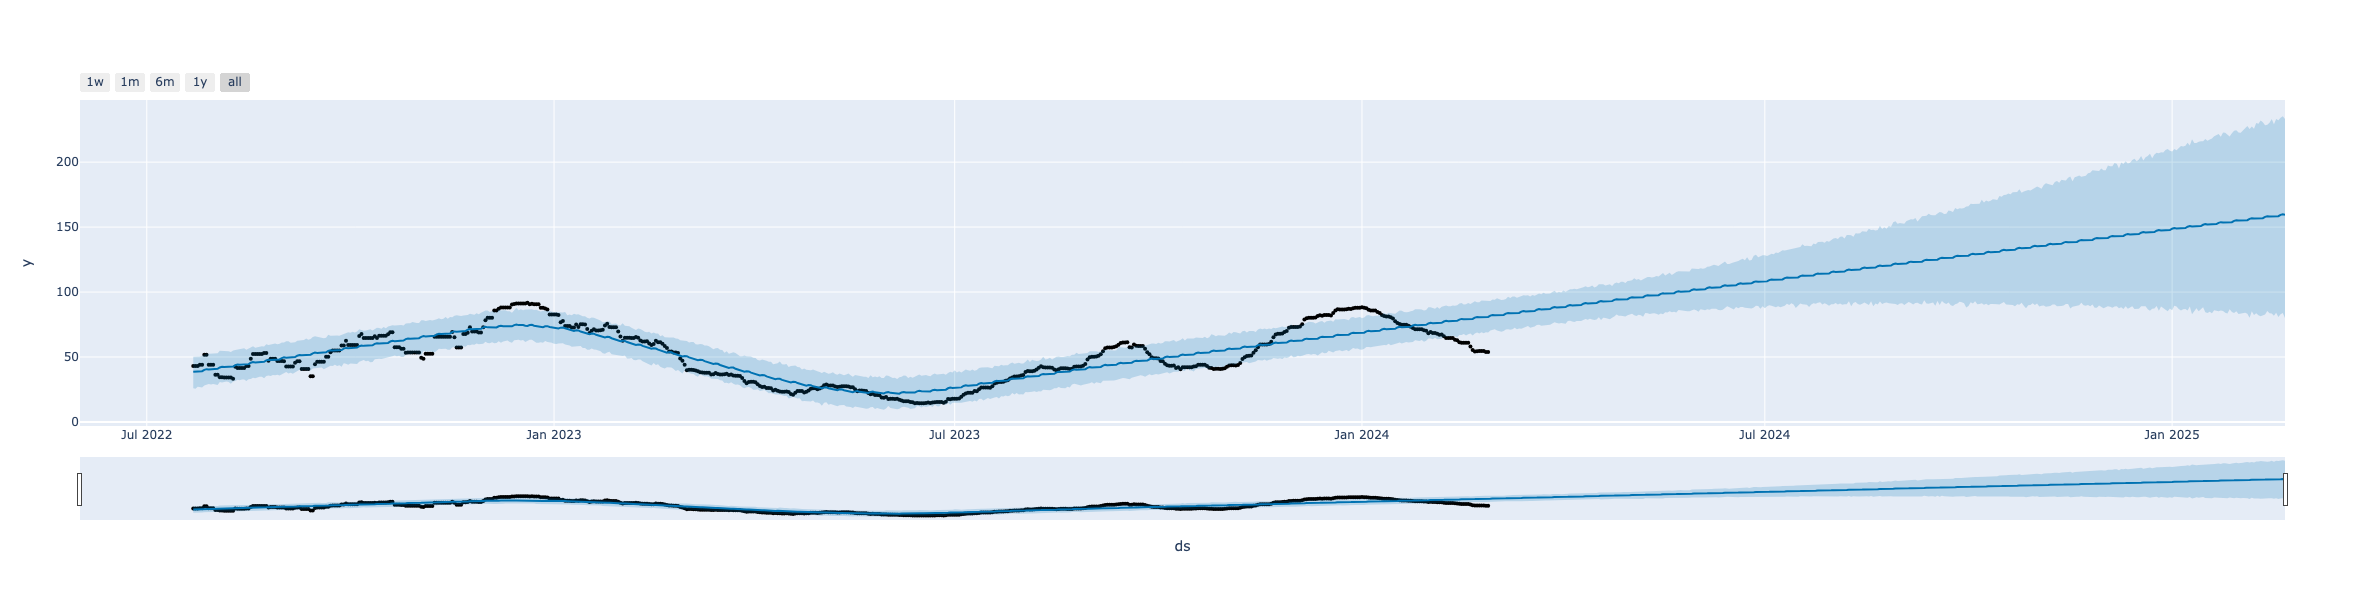

In [52]:
ph_df_nj = avg[['date_start', 'percentile']].rename(columns={'date_start':'ds', 'percentile':'y'})

m = Prophet()
m.fit(ph_df_nj)

future = m.make_future_dataframe(periods=360)
future.tail()

forecast = m.predict(future)

plot_plotly(m, forecast)

In [34]:
case.head()

,Geography,Date,weekly_case,dt
0,New Jersey,Mar 9 2024,390.0,2024-03-09
1,New Jersey,Mar 2 2024,521.0,2024-03-02
2,New Jersey,Feb 24 2024,552.0,2024-02-24
3,New Jersey,Feb 17 2024,646.0,2024-02-17
4,New Jersey,Feb 10 2024,694.0,2024-02-10


22:11:42 - cmdstanpy - INFO - Chain [1] start processing
22:11:42 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



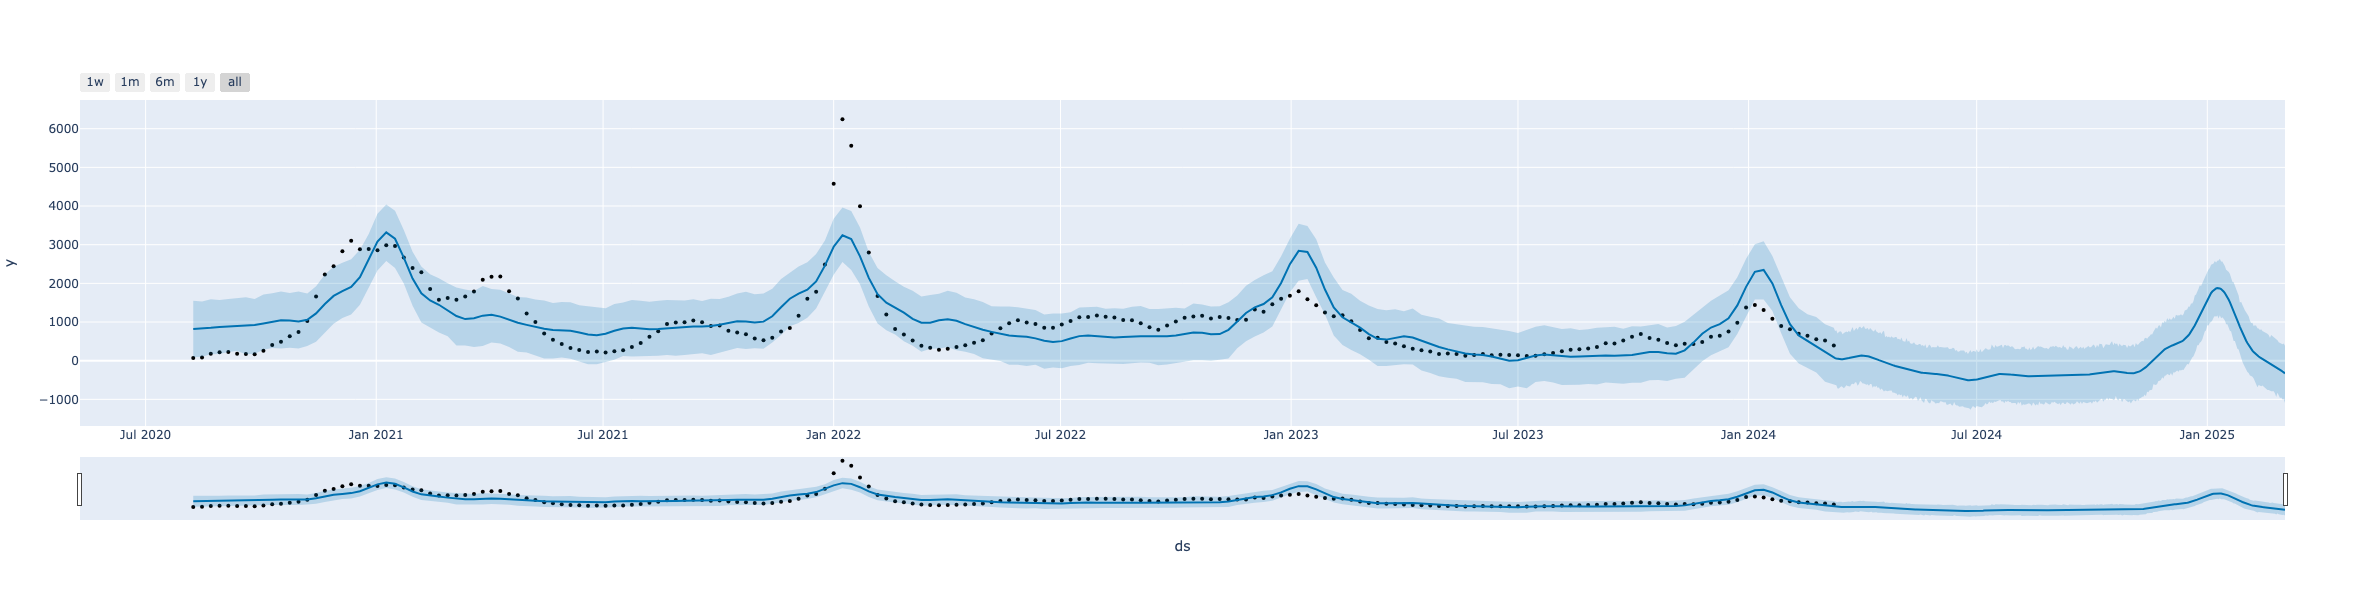

In [53]:
ph_case = case[['dt', 'weekly_case']].rename(columns={'dt':'ds', 'weekly_case':'y'})

m = Prophet()
m.fit(ph_case)

future = m.make_future_dataframe(periods=360)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

plot_plotly(m, forecast)

/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



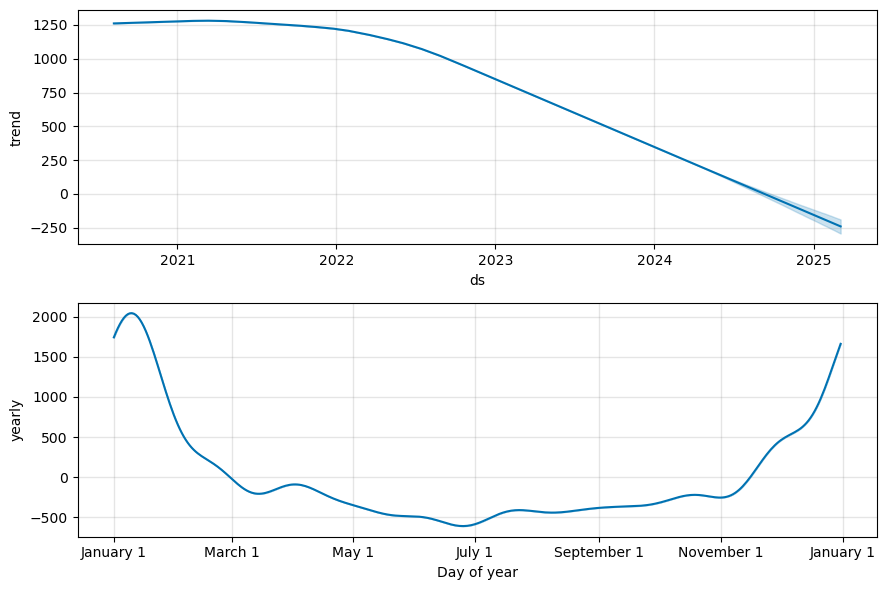

In [55]:
fig2 = m.plot_components(forecast)